<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'> State Space Model</font></h3>

In [4]:
install.packages('dlm')


  There is a binary version available but the source version is later:
    binary source needs_compilation
dlm  1.1-5  1.1-6              TRUE

  Binaries will be installed
package 'dlm' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\satyk\AppData\Local\Temp\RtmpSSxLAv\downloaded_packages


Warning message:
"package 'dlm' was built under R version 3.6.3"

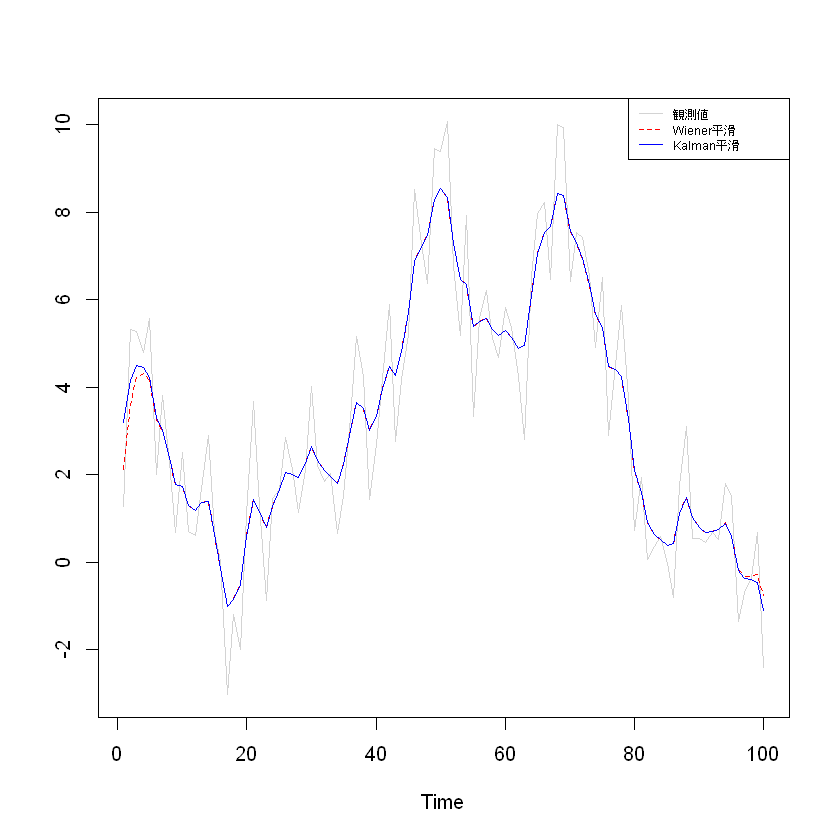

In [5]:
# Wiener and Kalman smoothings for the AR(1) model
# ライブラリの読み込み
set.seed(23)
library(dlm)

# 状態空間モデル（AR(1)モデルを含む）の設定
W <- 1
V <- 2
phi <- 0.98 # AR(1)の係数
mod <- dlmModPoly(order = 1, dW = W, dV = V, C0 = 100)
mod$GG[1, 1] <- phi

# Kalman予測を使用して観測値を生成
t_max <- 100
sim_data <- dlmForecast(mod = mod, nAhead = t_max, sampleNew = 1)
y <- sim_data$newObs[[1]]

# Kalman平滑
dlmSmoothed_obj <- dlmSmooth(y = y, mod = mod)
s <- dropFirst(dlmSmoothed_obj$s)

# Wiener平滑
# 係数の設定
r <- V / W
b <- 1/(r*phi) + 1/phi + phi
beta <- (b - sqrt(b^2 - 4)) / 2

# 有限の観測値の前後に最低限必要なダミーの0を補完
y_expand <- c(rep(0, t_max - 1), y, rep(0, t_max - 1))

# Wiener平滑の実行
d <- (1/phi - beta)*(phi - beta) / (1 - beta^2) *
  filter(method = "convolution",
         filter = beta^abs(-(t_max-1):(t_max-1)), x = y_expand
  )

# 結果からダミーのNAを削除
d <- d[!is.na(d)]

# 結果のプロット
ts.plot(cbind(y, d, s),
        lty = c("solid", "dashed", "solid"),
        col = c("lightgray", "red", "blue"),
        ylab = "")

# 凡例
legend(legend = c("観測値", "Wiener平滑", "Kalman平滑"),
       lty = c("solid", "dashed", "solid"),
       col = c("lightgray", "red", "blue"),
       x = "topright", text.width = 17, cex = 0.6)

In [7]:
#一つの時間点でフィルタリングを実行する関数の定義
kalman_filtering <- function(m_t_minus_1, t){
  #一時点先の予測分布
  a_t <- G_t %*% m_t_minus_1
  R_t <- G_t %*% C_t_minus_1 %*% t(G_t) + W_t

  #一時点先の予測尤度
  f_t <- F_t %*% a_t
  Q_t <- F_t %*% R_t %*% t(F_t) + V_t

  #カルマンゲイン
  K_t <- R_t %*% t(F_t) %*% solve(Q_t)

  #状態の更新
  m_t <- a_t + k_t %*% (y[t] - f_t)
  C_t <- (diag(nrow(R_t)) - K_t %*% F_t) %*% R_t

  #フィルタリング分布の平均と分散(および一時点先予測分布)を返す。
  return(list(m = m_t, C=C_t, a= a_t, R=R_t))
}

  #線形ガウス状態空間モデルのパラメータの設定(すべて1×1の行列)
  G_t <- matrix(1, ncol=1, nrow=1)
  W_t <- matrix(exp(7.29), ncol=1, nrow=1)
  F_t <- matrix(1, ncol=1, nrow=1)
  V_t <- matrix(exp(9.63), ncol=1, nrow=1)
  m0 <- matrix(0, ncol=1, nrow=1)
  C0 <- matrix(1e+7, ncol=1, nrow=1)

  #フィルタリング分布の平均と分散、および一時点先予測分布を計算

  #状態(平均と共分散)のメモリ確保
  m <- rep(NA_real_, t_max)
  C <- rep(NA_real_, t_max)
  a <- rep(NA_real_, t_max)
  R <- rep(NA_real_, t_max)

  #時間点: t=1
  KF <- Kalman_filtering(m0, C0, t=1)
  m[1] <- KF$C
  C[1] <- KF$a
  a[1] <- KF$a
  R[1] <- KF$R

  #時間点: t=2からt_max
  for (t in 2:t_max) {
     KF <- Kalman_filtering(m[t-1], C[t-1], t=t)
     m[t] <- KF$m
     C[t] <- KF$C
     a[t] <- KF$a
     R[t] <- KF$R
}


ERROR: Error in Kalman_filtering(m0, C0, t = 1):  関数 "Kalman_filtering" を見つけることができませんでした 
